In [2]:
# Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import seaborn as sea
import matplotlib.pyplot as plot
from simple_colors import *

In [3]:
# Read in data
data = pd.read_csv("countypres_2000-2020.csv")
data.tail()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL
72616,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3107,3560,20220315,TOTAL


In [4]:
# Remove rows that are neither Democrat or Republican, and remove all that are not the total vote
data = data.loc[(data['party'].isin(['DEMOCRAT','REPUBLICAN'])) & (data['mode'] == 'TOTAL')].reset_index(drop=True)

In [5]:
# Add column to data set to display voter confidence and winner
conf = [data['candidatevotes']/data['totalvotes']][0]
data['conf'] = conf
party_conf = conf
winner = [-1 for i in data.index]
for index in data.index:
    if data['party'][index]=='REPUBLICAN':
        party_conf[index] *= -1
    if index % 2 == 0 and index != data.index[-1]:
        if data['conf'][index] > data['conf'][index+1]:
            winner[index] = 1
        else:
            winner[index] = 0
    elif index % 2 == 1 and index != data.index[0]:
        if data['conf'][index] > data['conf'][index-1]:
            winner[index] = 1
        else:
            winner[index] = 0
data['party_conf'] = party_conf
data['winner'] = winner
data.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode,conf,party_conf,winner
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL,0.287192,0.287192,0
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL,0.696943,-0.696943,1
2,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL,0.247822,0.247822,0
3,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,40872,56480,20220315,TOTAL,0.723654,-0.723654,1
4,2000,ALABAMA,AL,BARBOUR,1005.0,US PRESIDENT,AL GORE,DEMOCRAT,5188,10395,20220315,TOTAL,0.499086,0.499086,1


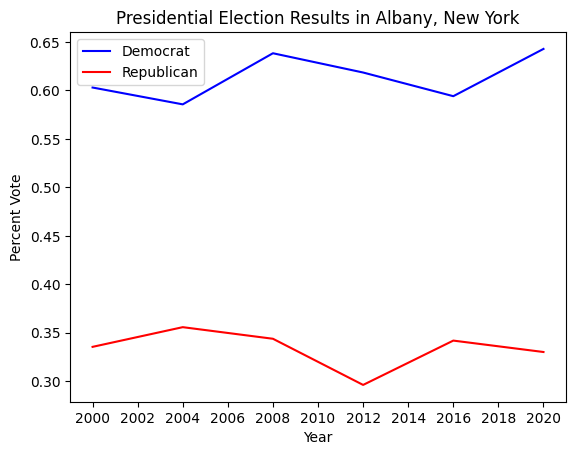

In [6]:
# Visualize temporal data (Albany, New York -- FIPS code 36001)
target_fips = 36001
target = data.loc[data['county_fips']==target_fips]
dem = target.loc[data['party']=='DEMOCRAT']
repub = target.loc[data['party']=='REPUBLICAN']
plot.locator_params(axis='x', nbins=len(target['year']))
plot.title("Presidential Election Results in Albany, New York")
plot.xlabel("Year")
plot.ylabel("Percent Vote")
plot.plot(dem['year'], dem['conf'], label='Democrat', color='blue')
plot.plot(repub['year'], repub['conf'], label='Republican', color='red')
plot.legend()

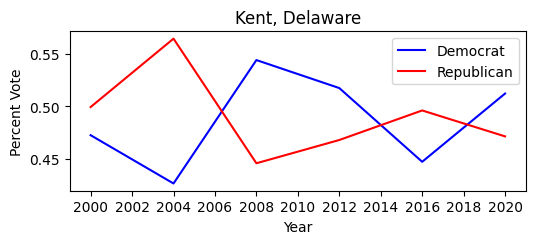

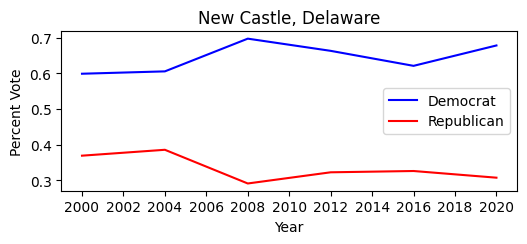

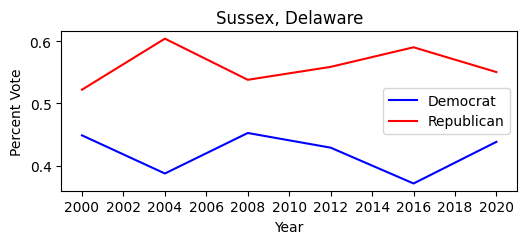

In [7]:
# Visualize election data differences across counties in a state (Arizona)
target=data.loc[data['state']=='DELAWARE']
fips = list(set(target['county_fips']))
for i in range(len(fips)):
    cur = target.loc[target['county_fips']==fips[i]]
    dem = cur.loc[data['party']=='DEMOCRAT']
    repub = cur.loc[data['party']=='REPUBLICAN']
    plot.figure(figsize=(20,12))
    plot.subplot(5, 3, i+1)
    plot.locator_params(axis='x', nbins=len(cur['year']))
    location = cur['county_name'][cur.index[0]].title() + ', ' + cur['state'][cur.index[0]].title()
    plot.title(location)
    plot.xlabel("Year")
    plot.ylabel("Percent Vote")
    plot.plot(dem['year'], dem['conf'], label='Democrat', color='blue')
    plot.plot(repub['year'], repub['conf'], label='Republican', color='red')
    plot.legend()
plot.show()
    

In [8]:
# Import 2020 census data for median ages and population size and combine with data
census = pd.read_csv("cc-est2021-agesex-all.csv", encoding='latin-1')
census['CTYNAME'] = census['CTYNAME'].apply(lambda x: str(x)[:-7].upper()) # remove word 'county' from CTYNAME column
census = census.loc[census['YEAR']==3][['CTYNAME', 'POPESTIMATE', 'POPEST_MALE', 'POPEST_FEM', 'MEDIAN_AGE_TOT', 'MEDIAN_AGE_MALE', 'MEDIAN_AGE_FEM']].reset_index(drop=True)
census['county_name'] = census['CTYNAME']
data = pd.merge(data, census, on='county_name').drop_duplicates(subset=['year', 'state', 'county_name', 'candidate']) # merge dataframes according to county and drop duplicates
data.drop(['CTYNAME', 'state_po', 'office', 'version', 'mode'], axis=1, inplace=True) # drop unneeded columns
data.sort_values(by=['county_fips', 'year'], inplace=True)
print(data.loc[(data['county_name']=='CLARK') & (data['state']=='NEVADA')])
data

       year   state county_name  county_fips          candidate       party  \
76902  2000  NEVADA       CLARK      32003.0            AL GORE    DEMOCRAT   
76914  2000  NEVADA       CLARK      32003.0     GEORGE W. BUSH  REPUBLICAN   
77190  2004  NEVADA       CLARK      32003.0         JOHN KERRY    DEMOCRAT   
77202  2004  NEVADA       CLARK      32003.0     GEORGE W. BUSH  REPUBLICAN   
77478  2008  NEVADA       CLARK      32003.0       BARACK OBAMA    DEMOCRAT   
77490  2008  NEVADA       CLARK      32003.0        JOHN MCCAIN  REPUBLICAN   
77766  2012  NEVADA       CLARK      32003.0       BARACK OBAMA    DEMOCRAT   
77778  2012  NEVADA       CLARK      32003.0        MITT ROMNEY  REPUBLICAN   
78054  2016  NEVADA       CLARK      32003.0    HILLARY CLINTON    DEMOCRAT   
78066  2016  NEVADA       CLARK      32003.0       DONALD TRUMP  REPUBLICAN   
78294  2020  NEVADA       CLARK      32003.0  JOSEPH R BIDEN JR    DEMOCRAT   
78306  2020  NEVADA       CLARK      32003.0     DON

,year,state,county_name,county_fips,candidate,party,candidatevotes,totalvotes,conf,party_conf,winner,POPESTIMATE,POPEST_MALE,POPEST_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,2000,ALABAMA,AUTAUGA,1001.0,AL GORE,DEMOCRAT,4942,17208,0.287192,0.287192,0,59095,28733,30362,39.3,38.3,40.3
1,2000,ALABAMA,AUTAUGA,1001.0,GEORGE W. BUSH,REPUBLICAN,11993,17208,0.696943,-0.696943,1,59095,28733,30362,39.3,38.3,40.3
2,2004,ALABAMA,AUTAUGA,1001.0,JOHN KERRY,DEMOCRAT,4758,20081,0.236940,0.236940,0,59095,28733,30362,39.3,38.3,40.3
3,2004,ALABAMA,AUTAUGA,1001.0,GEORGE W. BUSH,REPUBLICAN,15196,20081,0.756735,-0.756735,1,59095,28733,30362,39.3,38.3,40.3
4,2008,ALABAMA,AUTAUGA,1001.0,BARACK OBAMA,DEMOCRAT,6093,23641,0.257730,0.257730,0,59095,28733,30362,39.3,38.3,40.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171289,2012,WYOMING,WESTON,56045.0,MITT ROMNEY,REPUBLICAN,2821,3359,0.839833,-0.839833,1,6745,3588,3157,44.7,44.0,45.6
171290,2016,WYOMING,WESTON,56045.0,HILLARY CLINTON,DEMOCRAT,299,3526,0.084799,0.084799,0,6745,3588,3157,44.7,44.0,45.6
171291,2016,WYOMING,WESTON,56045.0,DONALD TRUMP,REPUBLICAN,3033,3526,0.860182,-0.860182,1,6745,3588,3157,44.7,44.0,45.6
171292,2020,WYOMING,WESTON,56045.0,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,0.101124,0.101124,0,6745,3588,3157,44.7,44.0,45.6


In [9]:
# Transform categorical data into numerical data
state_encoder = LabelEncoder()
val = state_encoder.fit_transform(data['state'])
data['state_num'] = val
party_encoder = LabelEncoder()
val = party_encoder.fit_transform(data['party'])
data['party_num'] = val
data

,year,state,county_name,county_fips,candidate,party,candidatevotes,totalvotes,conf,party_conf,winner,POPESTIMATE,POPEST_MALE,POPEST_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,state_num,party_num
0,2000,ALABAMA,AUTAUGA,1001.0,AL GORE,DEMOCRAT,4942,17208,0.287192,0.287192,0,59095,28733,30362,39.3,38.3,40.3,0,0
1,2000,ALABAMA,AUTAUGA,1001.0,GEORGE W. BUSH,REPUBLICAN,11993,17208,0.696943,-0.696943,1,59095,28733,30362,39.3,38.3,40.3,0,1
2,2004,ALABAMA,AUTAUGA,1001.0,JOHN KERRY,DEMOCRAT,4758,20081,0.236940,0.236940,0,59095,28733,30362,39.3,38.3,40.3,0,0
3,2004,ALABAMA,AUTAUGA,1001.0,GEORGE W. BUSH,REPUBLICAN,15196,20081,0.756735,-0.756735,1,59095,28733,30362,39.3,38.3,40.3,0,1
4,2008,ALABAMA,AUTAUGA,1001.0,BARACK OBAMA,DEMOCRAT,6093,23641,0.257730,0.257730,0,59095,28733,30362,39.3,38.3,40.3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171289,2012,WYOMING,WESTON,56045.0,MITT ROMNEY,REPUBLICAN,2821,3359,0.839833,-0.839833,1,6745,3588,3157,44.7,44.0,45.6,48,1
171290,2016,WYOMING,WESTON,56045.0,HILLARY CLINTON,DEMOCRAT,299,3526,0.084799,0.084799,0,6745,3588,3157,44.7,44.0,45.6,48,0
171291,2016,WYOMING,WESTON,56045.0,DONALD TRUMP,REPUBLICAN,3033,3526,0.860182,-0.860182,1,6745,3588,3157,44.7,44.0,45.6,48,1
171292,2020,WYOMING,WESTON,56045.0,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,0.101124,0.101124,0,6745,3588,3157,44.7,44.0,45.6,48,0


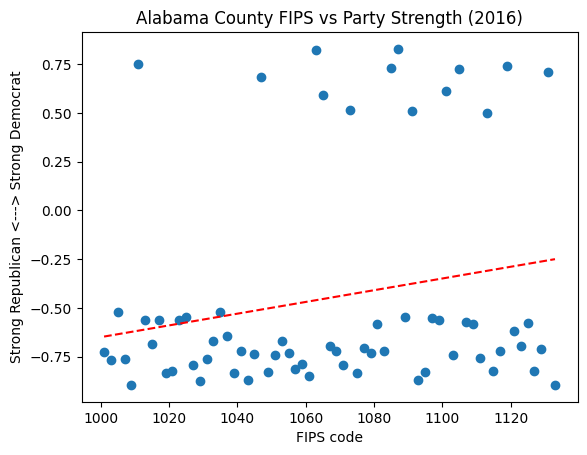

In [10]:
# Display correlation between fips code and party strength for 2016
plot.title("Alabama County FIPS vs Party Strength (2016)")
plot.xlabel("FIPS code")
plot.ylabel("Strong Republican <---> Strong Democrat")
selection = data.loc[(data['year']==2016) & (data['state']=='ALABAMA') & (data['winner']==1)]
plot.scatter(selection['county_fips'], selection['party_conf'])
z = np.polyfit(selection['county_fips'], selection['party_conf'], 1)
p = np.poly1d(z)
plot.plot(selection['county_fips'], p(selection['county_fips']), 'r--')


In [11]:
# Preprocess and split data for classifier
X = data[['year', 'county_fips', 'POPESTIMATE', 'POPEST_MALE', 'POPEST_FEM', 'MEDIAN_AGE_TOT',\
           'MEDIAN_AGE_MALE', 'MEDIAN_AGE_FEM', 'state_num', 'party_num']]
Y = data['winner']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.head()

,year,county_fips,POPESTIMATE,POPEST_MALE,POPEST_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,state_num,party_num
104094,2000,36047.0,153443,84786,68657,32.4,32.9,31.7,30,1
161308,2016,36015.0,83045,41441,41604,41.8,40.5,43.3,30,0
38412,2020,17103.0,177218,87445,89773,33.7,32.4,35.0,11,0
169848,2008,51011.0,16353,7990,8363,42.3,41.3,43.3,44,0
78495,2016,37045.0,7514,3713,3801,44.2,43.8,44.5,31,1


In [12]:
# Build classifier and verify accuracy
model = HistGradientBoostingClassifier()
model.fit(X_train, Y_train)
cv_score = cross_val_score(model, X_test, Y_test, cv=20).mean()
print("Cross Validation Score: " + str(cv_score))

Cross Validation Score: 0.8264224665207314


In [13]:
# Get info about specific county
county_name = 'PIMA'
state_name = 'ARIZONA'
pred_val = data.loc[(data['county_name']==county_name) & (data['state']==state_name)]
pred_val = pred_val.head(1)

In [14]:
# Predict for 2024 election
pred_X = pred_val.drop(['state', 'county_name', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'conf', 'party_conf', 'winner'], axis=1)
pred_X['year'] = 2024
pred_X['party_num'] = 0
prediction = model.predict(pred_X)
val = 'Democrat' if prediction[0] == 1 else 'Republican'
print('The model predicts that ' + county_name.title() + ' County, ' + state_name.title() + ' will vote ' + val + ' in 2024.')

The model predicts that Pima County, Arizona will vote Democrat in 2024.


In [15]:
# Predict for all counties in a state
state_name = 'NEW YORK'
selection = data.loc[data['state']==state_name].drop_duplicates(subset='county_name')
selection = selection.sort_values(by='POPESTIMATE', ascending=False)
prediction_colors = []
for county_name in selection['county_name']:
    pred_val = selection.loc[data['county_name']==county_name]
    pred_val = pred_val.head()
    pred_X = pred_val.drop(['state', 'county_name', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'conf', 'party_conf', 'winner'], axis=1)
    pred_X['year'] = 2024
    pred_X['party_num'] = 0
    prediction = model.predict(pred_X)
    prediction_color = 'blue' if prediction[0] == 1 else 'red'
    prediction_colors.append(prediction_color)
    val = 'Democrat' if prediction[0] == 1 else 'Republican'
    val = blue(val, ['bold']) if val == 'Democrat' else red(val, ['bold'])
    population = '{:,}'.format(pred_X['POPESTIMATE'].values.tolist()[0])
    print(black(county_name.title() + ' County, '+ state_name.title(), ['bold']) + ' (est. population ' \
          + population + ') will vote ' + val + ' in 2024.')

Orange County, New York (est. population 3,167,809) will vote Democrat in 2024.
Queens County, New York (est. population 2,331,143) will vote Democrat in 2024.
New York County, New York (est. population 1,576,876) will vote Democrat in 2024.
Bronx County, New York (est. population 1,424,948) will vote Democrat in 2024.
Westchester County, New York (est. population 997,895) will vote Democrat in 2024.
Erie County, New York (est. population 950,683) will vote Democrat in 2024.
Essex County, New York (est. population 807,074) will vote Democrat in 2024.
Suffolk County, New York (est. population 771,245) will vote Democrat in 2024.
Jefferson County, New York (est. population 667,820) will vote Democrat in 2024.
Onondaga County, New York (est. population 473,236) will vote Democrat in 2024.
Genesee County, New York (est. population 404,208) will vote Republican in 2024.
Madison County, New York (est. population 395,211) will vote Republican in 2024.
Orleans County, New York (est. population

<BarContainer object of 62 artists>

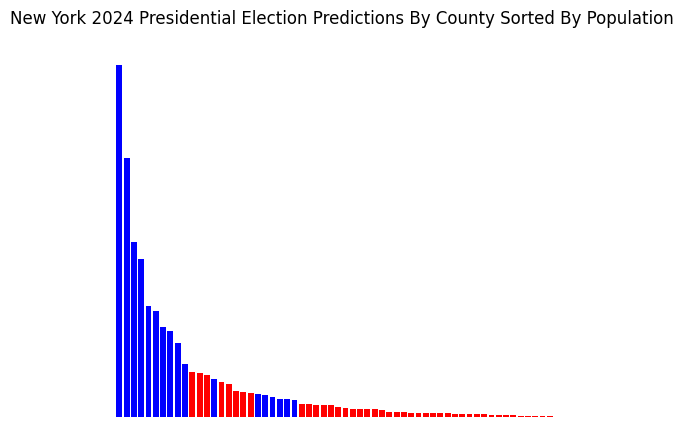

In [16]:
# Visualize data with a bar graph
plot.title(state_name.title() + ' 2024 Presidential Election Predictions By County Sorted By Population')
plot.axis('off')
plot.bar([i for i in range(len(selection))], selection['POPESTIMATE'], color=prediction_colors)

<BarContainer object of 200 artists>

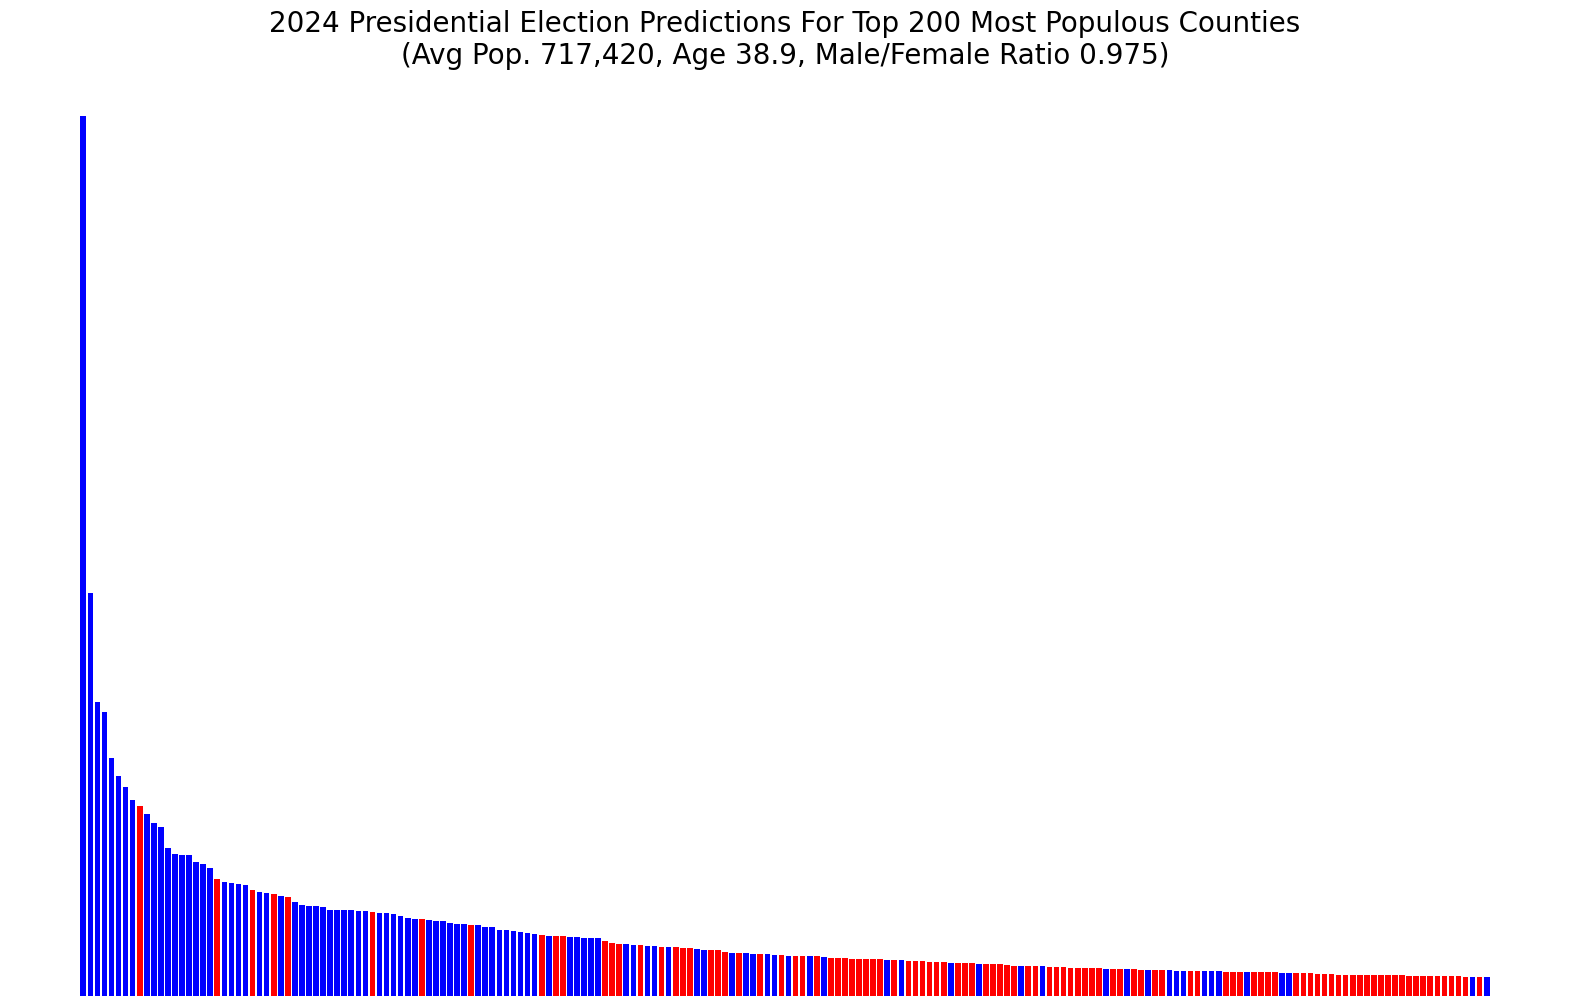

In [17]:
# Gather and display predictions for the top 200 most populous counties
selection = data.drop_duplicates(subset='county_name').nlargest(200, 'POPESTIMATE')
selection = selection.sort_values(by='POPESTIMATE', ascending=False)
prediction_colors = []
for county_name in selection['county_name']:
    pred_val = selection.loc[data['county_name']==county_name]
    pred_val = pred_val.head()
    pred_X = pred_val.drop(['state', 'county_name', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'conf', 'party_conf', 'winner'], axis=1)
    pred_X['year'] = 2024
    pred_X['party_num'] = 0
    prediction = model.predict(pred_X)
    prediction_color = 'blue' if prediction[0] == 1 else 'red'
    prediction_colors.append(prediction_color)
mean_pop = '{:,}'.format(int(selection['POPESTIMATE'].mean()))
mean_age = str(round(selection['MEDIAN_AGE_TOT'].mean(), 1))
male_fem_ratio = str(round(selection['POPEST_MALE'].mean()/selection['POPEST_FEM'].mean(), 3))
plot.figure(figsize=(20, 12))
plot.title('2024 Presidential Election Predictions For Top 200 Most Populous Counties\n(Avg Pop. ' + mean_pop + ', Age ' + mean_age + ', Male/Female Ratio ' + male_fem_ratio + ')', fontsize=20)
plot.axis('off')
plot.bar([i for i in range(len(selection))], selection['POPESTIMATE'], color=prediction_colors)

<BarContainer object of 200 artists>

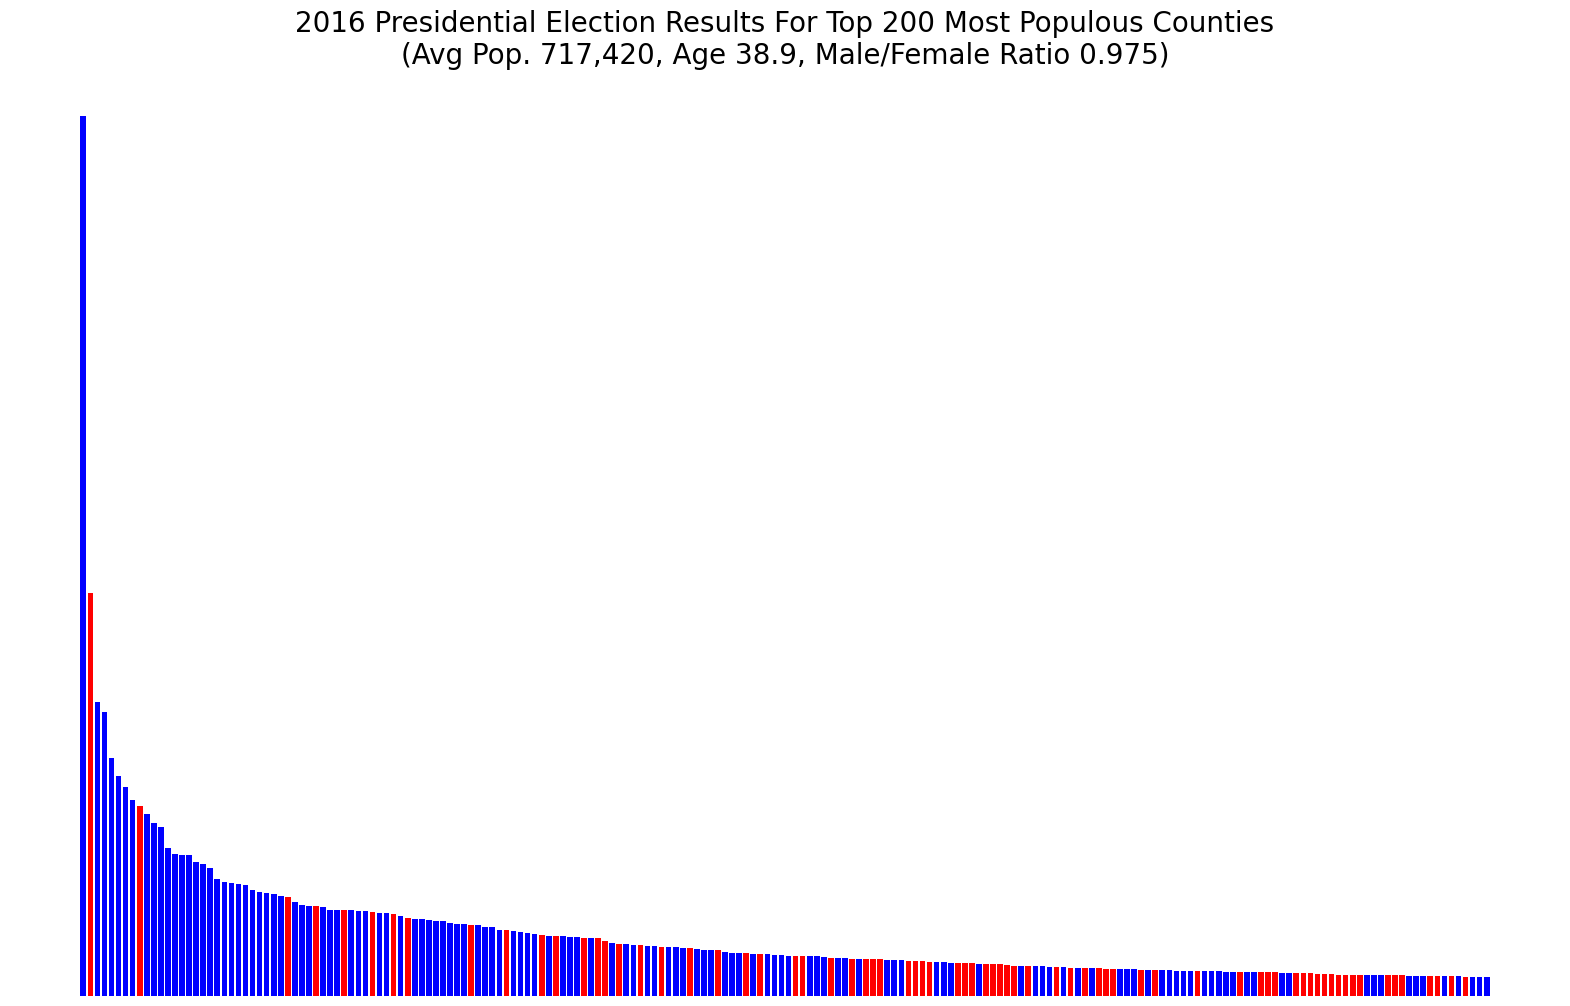

In [18]:
# Gather and display results for the 2016 election for the top 200 most populous counties
selection = data.loc[(data['year']==2016) & (data['winner']==1)]
selection = selection.drop_duplicates(subset='county_name').nlargest(200, 'POPESTIMATE')
selection = selection.sort_values(by='POPESTIMATE', ascending=False)
prediction_colors = ['green' for i in range(len(selection))]
for i in range(len(selection)):
    prediction_colors[i] = 'blue' if selection['party'][selection.index[i]] == 'DEMOCRAT' else 'red'
mean_pop = '{:,}'.format(int(selection['POPESTIMATE'].mean()))
mean_age = str(round(selection['MEDIAN_AGE_TOT'].mean(), 1))
male_fem_ratio = str(round(selection['POPEST_MALE'].mean()/selection['POPEST_FEM'].mean(), 3))
plot.figure(figsize=(20, 12))
plot.title('2016 Presidential Election Results For Top 200 Most Populous Counties\n(Avg Pop. ' + mean_pop + ', Age ' + mean_age + ', Male/Female Ratio ' + male_fem_ratio + ')', fontsize=20)
plot.axis('off')
plot.bar([i for i in range(len(selection))], selection['POPESTIMATE'], color=prediction_colors)

<BarContainer object of 200 artists>

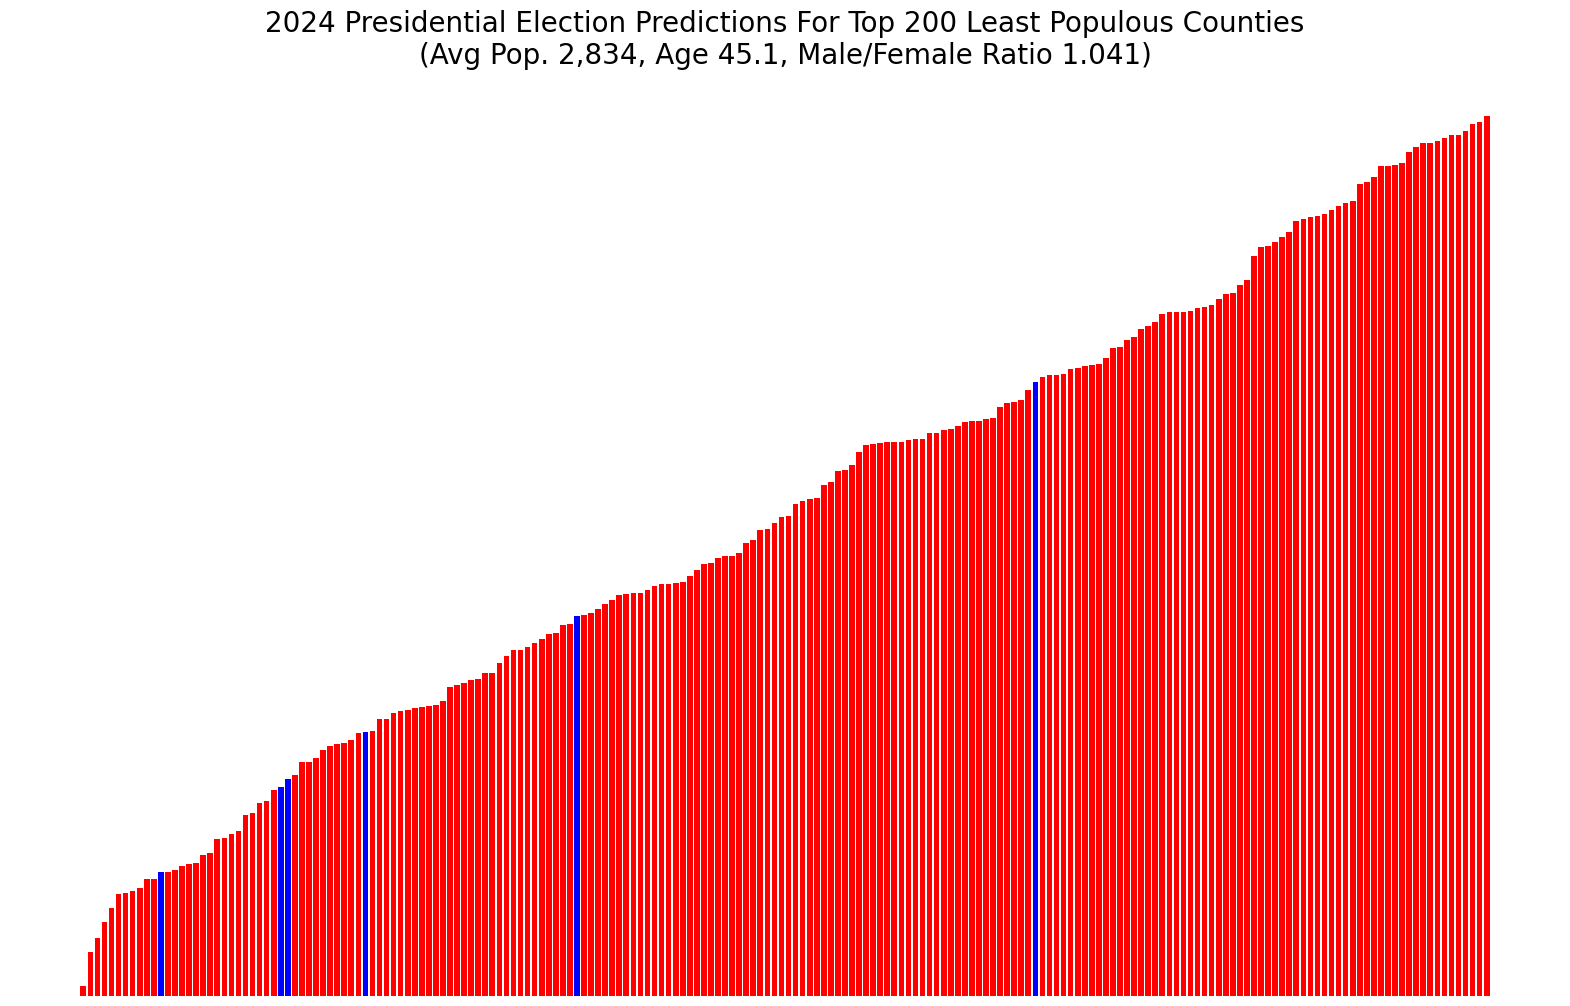

In [19]:
# Gather and display predictions for the top 200 least populous counties
selection = data.drop_duplicates('county_name').nsmallest(200, 'POPESTIMATE')
selection = selection.sort_values(by='POPESTIMATE')
prediction_colors = []
for county_name in selection['county_name']:
    pred_val = selection.loc[data['county_name']==county_name]
    pred_val = pred_val.head()
    pred_X = pred_val.drop(['state', 'county_name', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'conf', 'party_conf', 'winner'], axis=1)
    pred_X['year'] = 2024
    pred_X['party_num'] = 0
    prediction = model.predict(pred_X)
    prediction_color = 'blue' if prediction[0] == 1 else 'red'
    prediction_colors.append(prediction_color)
mean_pop = '{:,}'.format(int(selection['POPESTIMATE'].mean()))
mean_age = str(round(selection['MEDIAN_AGE_TOT'].mean(), 1))
male_fem_ratio = str(round(selection['POPEST_MALE'].mean()/selection['POPEST_FEM'].mean(), 3))
plot.figure(figsize=(20, 12))
plot.title('2024 Presidential Election Predictions For Top 200 Least Populous Counties\n(Avg Pop. ' + mean_pop + ', Age ' + mean_age + ', Male/Female Ratio ' + male_fem_ratio + ')', fontsize=20)
plot.axis('off')
plot.bar([i for i in range(len(selection))], selection['POPESTIMATE'], color=prediction_colors, picker=True)

<BarContainer object of 200 artists>

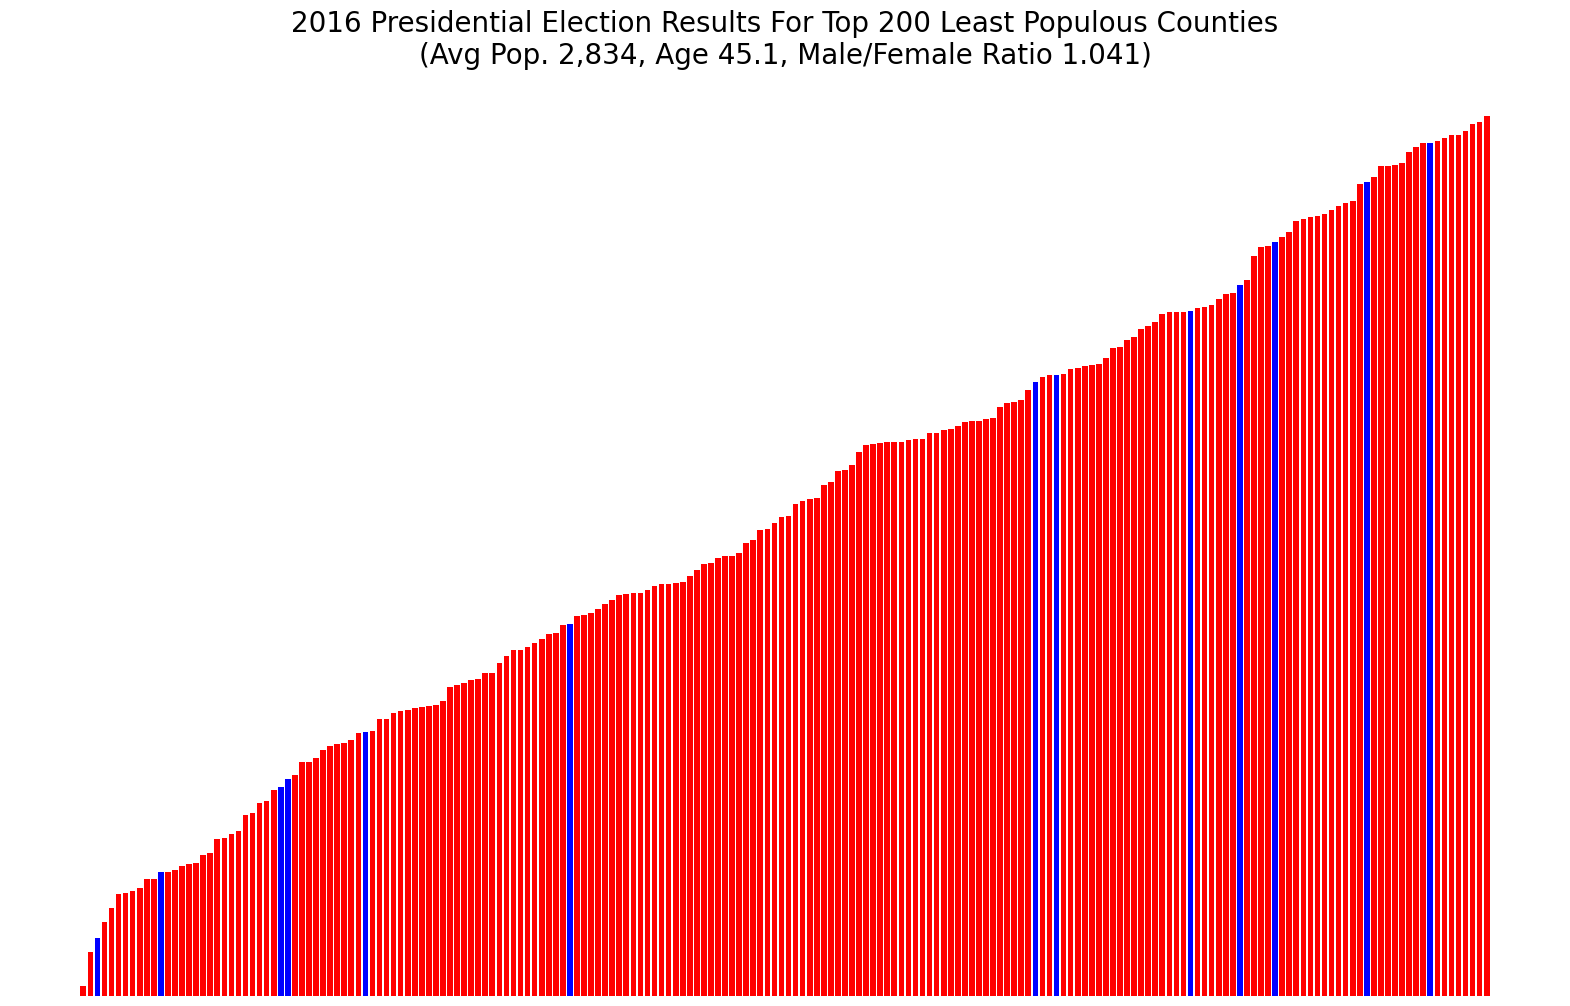

In [20]:
# Gather and display results for the 2016 election for the top 200 least populous counties
selection = data.loc[(data['year']==2016) & (data['winner']==1)]
selection = selection.drop_duplicates(subset='county_name').nsmallest(200, 'POPESTIMATE')
selection = selection.sort_values(by='POPESTIMATE')
prediction_colors = ['green' for i in range(len(selection))]
for i in range(len(selection)):
    prediction_colors[i] = 'blue' if selection['party'][selection.index[i]] == 'DEMOCRAT' else 'red'
mean_pop = '{:,}'.format(int(selection['POPESTIMATE'].mean()))
mean_age = str(round(selection['MEDIAN_AGE_TOT'].mean(), 1))
male_fem_ratio = str(round(selection['POPEST_MALE'].mean()/selection['POPEST_FEM'].mean(), 3))
plot.figure(figsize=(20, 12))
plot.title('2016 Presidential Election Results For Top 200 Least Populous Counties\n(Avg Pop. ' + mean_pop + ', Age ' + mean_age + ', Male/Female Ratio ' + male_fem_ratio + ')', fontsize=20)
plot.axis('off')
plot.bar([i for i in range(len(selection))], selection['POPESTIMATE'], color=prediction_colors)

In [46]:
# Gather predictions for all counties
final = data[['county_name', 'POPESTIMATE', 'county_fips', 'MEDIAN_AGE_TOT', 'MEDIAN_AGE_MALE', 'MEDIAN_AGE_FEM', 'POPEST_MALE', 'POPEST_FEM']].drop_duplicates(subset='county_name').sort_values(by='POPESTIMATE', ascending=False)
predictions = []
prediction_colors = []
counties = data.drop_duplicates(subset='county_name').sort_values(by='POPESTIMATE', ascending=False)
for val in counties['county_name']:
    county = counties.loc[counties['county_name']==val].drop(['state', 'county_name', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'conf', 'party_conf', 'winner'], axis=1)
    county['year'] = 2024
    county['party_num'] = 0
    prediction = model.predict(county)
    if prediction[0] == 1:
        predictions.append(0)
        prediction_colors.append('blue')
    else:
        predictions.append(1)
        prediction_colors.append('red')
final['prediction'] = predictions
final['colors'] = prediction_colors

<BarContainer object of 1000 artists>

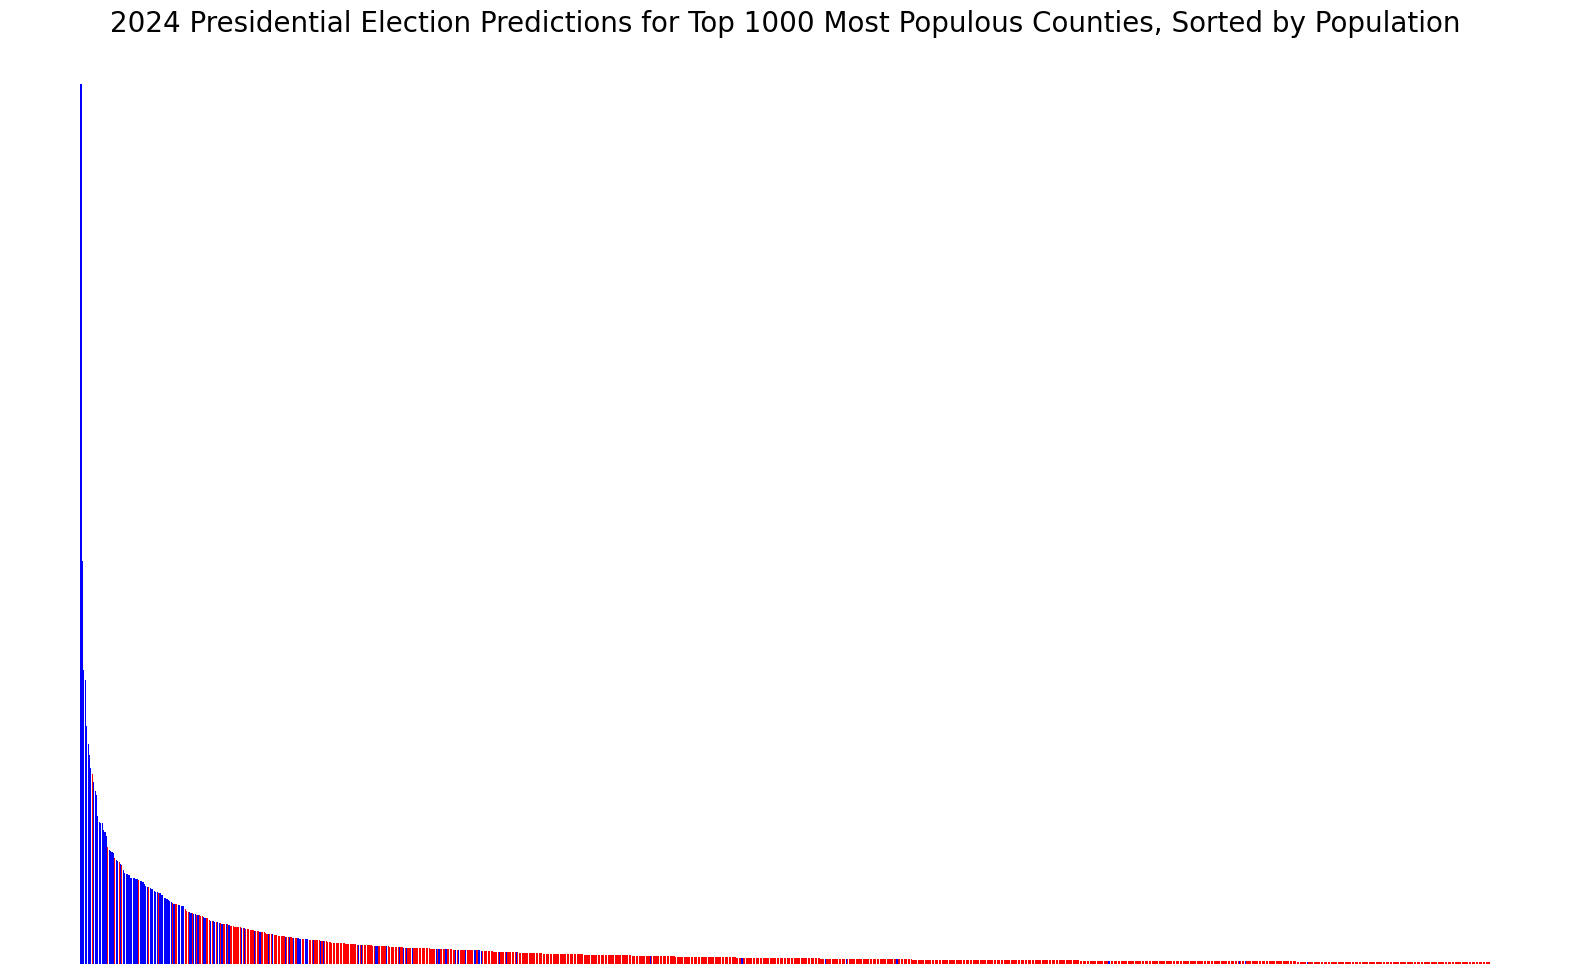

In [47]:
# Display predictions for top 1000 most populous counties sorted by population
final_selection = final.nlargest(1000, 'POPESTIMATE')
plot.figure(figsize=(20, 12))
plot.title('2024 Presidential Election Predictions for Top 1000 Most Populous Counties, Sorted by Population', fontsize=20)
plot.axis('off')
plot.bar([i for i in range(len(final_selection))], final_selection['POPESTIMATE'], color=final_selection['colors'])

In [78]:
# Report statistics for predictions
dem_predictions = final.loc[final['prediction']==0]
repub_predictions = final.loc[final['prediction']==1]

def conv(val, num, type='mean'):
    if type == 'med':
        if num == 0:
            return '{:,}'.format(int(val.median()))
        else:
            return '{:,}'.format(round(val.median(), num))
    else:
        if num == 0:
            return '{:,}'.format(int(val.mean()))
        else:
            return '{:,}'.format(round(val.mean(), num))

print('STATISTICS FOR COUNTIES PREDICTED AS VOTING MAJORITY DEMOCRAT IN 2024 PRESIDENTIAL ELECTION\n')
print('Number of Counties: ' + '{:,}'.format(len(dem_predictions)))
print('Approx. Number of Votes: ' + '{:,}'.format(int(len(dem_predictions) * dem_predictions['POPESTIMATE'].mean() * 0.668)))
print('\nMean Population: ' + conv(dem_predictions['POPESTIMATE'], 0))
print('Median Population: ' + conv(dem_predictions['POPESTIMATE'], 0, type='med'))
print('Mean Male Population: ' + conv(dem_predictions['POPEST_MALE'], 0))
print('Median Male Population: ' + conv(dem_predictions['POPEST_MALE'], 0, type='med'))
print('Mean Female Population: ' + conv(dem_predictions['POPEST_FEM'], 0))
print('Median Female Population: ' + conv(dem_predictions['POPEST_FEM'], 0, type='med'))
print('Mean Male/Female Ratio: ' + conv(dem_predictions['POPEST_MALE']/dem_predictions['POPEST_FEM'], 3))
print('Median Male/Female Ratio: ' + conv(dem_predictions['POPEST_MALE']/dem_predictions['POPEST_FEM'], 3, type='med'))
print('Mean Age: ' + conv(dem_predictions['MEDIAN_AGE_TOT'], 1))
print('Median Age: ' + conv(dem_predictions['MEDIAN_AGE_TOT'], 1, type='med'))
print('Mean Male Age: ' + conv(dem_predictions['MEDIAN_AGE_MALE'], 1))
print('Median Male Age: ' + conv(dem_predictions['MEDIAN_AGE_MALE'], 1, type='med'))
print('Mean Female Age: ' + conv(dem_predictions['MEDIAN_AGE_FEM'], 1))
print('Median Female Age: ' + conv(dem_predictions['MEDIAN_AGE_FEM'], 1, type='med'))

print('\n-------------------------------------------------------------------------------------------\n')

print('STATISTICS FOR COUNTIES PREDICTED AS VOTING MAJORITY REPUBLICAN IN 2024 PRESIDENTIAL ELECTION\n')
print('Number of Counties: ' + '{:,}'.format(len(repub_predictions)))
print('Approx. Number of Votes: ' + '{:,}'.format(int(len(repub_predictions) * repub_predictions['POPESTIMATE'].mean() * 0.668)))
print('\nMean Population: ' + conv(repub_predictions['POPESTIMATE'], 0))
print('Median Population: ' + conv(repub_predictions['POPESTIMATE'], 0, type='med'))
print('Mean Male Population: ' + conv(repub_predictions['POPEST_MALE'], 0))
print('Median Male Population: ' + conv(repub_predictions['POPEST_MALE'], 0, type='med'))
print('Mean Female Population: ' + conv(repub_predictions['POPEST_FEM'], 0))
print('Median Female Population: ' + conv(repub_predictions['POPEST_FEM'], 0, type='med'))
print('Mean Male/Female Ratio: ' + conv(repub_predictions['POPEST_MALE']/repub_predictions['POPEST_FEM'], 3))
print('Median Male/Female Ratio: ' + conv(repub_predictions['POPEST_MALE']/repub_predictions['POPEST_FEM'], 3, type='med'))
print('Mean Age: ' + conv(repub_predictions['MEDIAN_AGE_TOT'], 1))
print('Median Age: ' + conv(repub_predictions['MEDIAN_AGE_TOT'], 1, type='med'))
print('Mean Male Age: ' + conv(repub_predictions['MEDIAN_AGE_MALE'], 1))
print('Median Male Age: ' + conv(repub_predictions['MEDIAN_AGE_MALE'], 1, type='med'))
print('Mean Female Age: ' + conv(repub_predictions['MEDIAN_AGE_FEM'], 1))
print('Median Female Age: ' + conv(repub_predictions['MEDIAN_AGE_FEM'], 1, type='med'))

STATISTICS FOR COUNTIES PREDICTED AS VOTING MAJORITY DEMOCRAT IN 2024 PRESIDENTIAL ELECTION

Number of Counties: 149
Approx. Number of Votes: 70,112,494

Mean Population: 704,421
Median Population: 462,718
Mean Male Population: 347,659
Median Male Population: 226,650
Mean Female Population: 356,762
Median Female Population: 234,233
Mean Male/Female Ratio: 0.991
Median Male/Female Ratio: 0.975
Mean Age: 39.4
Median Age: 39.2
Mean Male Age: 38.2
Median Male Age: 38.0
Mean Female Age: 40.7
Median Female Age: 40.4

-------------------------------------------------------------------------------------------

STATISTICS FOR COUNTIES PREDICTED AS VOTING MAJORITY REPUBLICAN IN 2024 PRESIDENTIAL ELECTION

Number of Counties: 1,628
Approx. Number of Votes: 67,616,879

Mean Population: 62,176
Median Population: 24,002
Mean Male Population: 30,945
Median Male Population: 12,114
Mean Female Population: 31,230
Median Female Population: 11,854
Mean Male/Female Ratio: 1.029
Median Male/Female Ratio: 1.